In [7]:
import numpy as np 
import matplotlib.pyplot as plt 
from math import gamma
from scipy.stats import gamma as gamma_dense
from scipy.special import psi as digamma 

from prml.utils.util import _log
from prml.utils.encoder import LabelToOnehot
from prml.mixture_models import KMeans

In [2]:
def gauss_distribution(x,mu,lamda):
    return (lamda/(2*np.pi))**0.5 * np.exp(-(x-mu)**2*lamda*0.5)

#  Posterior distribution for 1D Gaussian 

In [3]:
class ApproximateGauss1D():
    def __init__(self,a=0,b=0,mu=0,lamda=0,max_iter=1000,threshold=1e-2):
        self.a = a 
        self.b = b 
        self.mu = mu 
        self.lamda = lamda 
        self.max_iter = max_iter 
        self.threshold = threshold

    def fit(self,X,init_tau=1.0):
        N = len(X)
        X_sum = X.sum()
        X2_sum = np.sum(X**2) 

        E_tau = init_tau
        mu_N = (self.lamda*self.mu + X_sum)/(self.lamda + N)
        lam_N = (self.lamda + N)*E_tau

        for _ in range(self.max_iter):
            E_mu = mu_N 
            E_mu2 = mu_N**2 + 1/((lam_N + N)*E_tau) 
            a_N = self.a + (N + 1)/2 
            b_N = self.b + 0.5*(X2_sum -2*E_mu*X_sum + N*E_mu2 + self.lamda*(E_mu2 - 2*E_mu*self.mu + self.mu**2)) 

            E_tau = a_N/b_N 
            new_mu_N = (self.lamda*self.mu + X_sum)/(self.lamda + N)
            new_lam_N = (self.lamda + N)*E_tau

            if ((new_lam_N - lam_N)**2 + (new_mu_N - mu_N)**2)**0.5 < self.threshold:
                lam_N = new_lam_N 
                mu_N = new_mu_N
                break 
        
            lam_N = new_lam_N
            mu_N = new_mu_N

        self.mu = mu_N
        self.lamda = lam_N
        self.a = a_N
        self.b = b_N

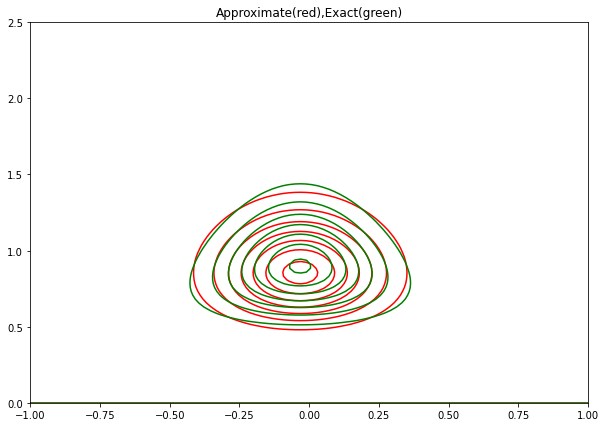

In [4]:
## parameter for prior distribution
a_0 = 0 
b_0 = 0 
mu_0 = 0 
lam_0 = 0 

## caluculate approximate posterior distribution
N = 30 
X_data = np.random.randn(N)
app_gauss1d = ApproximateGauss1D(max_iter=100,threshold=1e-7,a=a_0,b=b_0,mu=mu_0,lamda=lam_0)
app_gauss1d.fit(X_data)


fig,ax = plt.subplots(1,1,figsize=(10,7))
x = np.linspace(-1,1,100)
y = np.linspace(0,2.5,100) 
X,Y = np.meshgrid(x,y)

## approximate solution
a = app_gauss1d.a 
b = app_gauss1d.b 
mu = app_gauss1d.mu 
lam = app_gauss1d.lamda 

prob = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        prob[i][j] = gamma_dense.pdf(Y[i][j],a=a,scale=1/b)*gauss_distribution(X[i][j],mu,lam)

ax.contour(X,Y,prob,colors=["red"])

## exact solution
a_N = a_0 + (N + 1)/2 
b_N = b_0 - (lam_0*mu_0 + N*X_data.mean())**2 / (2*(lam_0 + N)) + lam_0*mu_0**2/2 + np.sum(X_data**2)/2 
mu_N = (lam_0*mu_0 + N*X_data.mean()) / (lam_0 + N) 
lam_N = N + lam_0

prob = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        prob[i][j] = gamma_dense.pdf(Y[i][j],a=a_N,scale=1/b_N)*gauss_distribution(X[i][j],mu_N,lam_N*Y[i][j])

ax.contour(X,Y,prob,colors=["green"])
ax.set_title("Approximate(red),Exact(green)")
plt.show()

# Ancestral Sampling

In [5]:
def make_data(n = 100,cluster = 3):
    if cluster == 2:
        X1 = np.random.randn(n,2) + 1 
        X2 = np.random.randn(n,2) - 1 
        X = np.vstack((X1,X2))
    elif cluster == 3: 
        X1 = np.random.randn(n,2) + 1 
        X2 = np.random.randn(n,2) - 1 
        X3 = np.random.randn(n,2) + np.array([0,1]) + np.array([-1,0])
        X = np.vstack((X1,X2,X3))
    return X

def gm_sampling(n=100,pi=None,mu=None,sigma=None):
    if pi is None:
        assert mu is None and sigma is None 
        pi = np.ones((3)) / 3 
        mu = np.array([
            np.array([1,1]),
            np.array([-1,-1]),
            np.array([1,-1])
        ])
        sigma = np.array([np.eye(2) for _ in range(3)])
    
    z = np.random.multinomial(1,pi,size=n) 
    X = np.zeros((n,mu.shape[1])) 
    N = np.sum(z,axis = 0)
    for k in range(pi.shape[0]):
        n_k = N[k]
        X[z[:,k] == 1,:] = np.random.multivariate_normal(mu[k],sigma[k],n_k)
    return X 

# Posterior distribution for Gaussian Mixture

In [8]:
class ApproximateGaussianMixture():
    def __init__(self,K,alpha=None,m=None,beta=1,W=None,nu=None,n_iter=1000):
        self.K = K
        if alpha is None:
            self.alpha = np.ones(self.K) 
        else:
            self.alpha = alpha 
        self.m = m 
        self.beta = beta 
        self.W = W 
        if nu is None:
            self.nu = 1 
        else:
            self.nu = nu
        self.n_iter = n_iter 

    def fit(self,X,initial_responsibility=None,reduce_components=False,threshold=1e-3):
        N = X.shape[0]
        M = X.shape[1]
        E_z = initial_responsibility
        self.m = np.zeros(M)
        self.W_inv = np.eye(M)
  
        for _ in range(self.n_iter):
            
            # M step like
            N_k = E_z.sum(axis = 0)
            x_k_bar = (E_z.T@X) / N_k.reshape(-1,1)
            tmp = X.reshape(N,1,M) - x_k_bar.reshape(1,self.K,M)
            S_k = np.sum(E_z.reshape(N,self.K,1,1)*(tmp.reshape(N,self.K,M,1)*tmp.reshape(N,self.K,1,M)),axis = 0) / N_k.reshape(-1,1,1) 

            alpha = self.alpha + N_k 
            beta = self.beta + N_k 
            m_k = (self.beta*self.m + N_k.reshape(-1,1)*x_k_bar) / beta.reshape(-1,1)
            tmp = x_k_bar - self.m
            W_k = np.linalg.inv(self.W_inv + N_k.reshape(-1,1,1)*S_k + (self.beta*N_k.reshape(-1,1,1)/(self.beta + N_k.reshape(-1,1,1)))*tmp.reshape(-1,M,1)*tmp.reshape(-1,1,M)) 
            nu = self.nu + N_k  

            # E step like
            E_pi = (self.alpha + N_k)/(self.K*self.alpha + N)
            if reduce_components:
                reduce = E_pi >= threshold
                self.alpha = self.alpha[reduce]
                alpha = alpha[reduce]
                beta = beta[reduce]
                m_k = m_k[reduce]
                W_k = W_k[reduce] 
                nu = nu[reduce]
                self.K = reduce.astype("int").sum()

            E_pi = digamma(alpha) - digamma(alpha.sum()) # E_logpi 
            E_Lam = digamma(0.5*(nu + 1 - np.arange(1,M+1,1).reshape(-1,1))).sum(axis = 0) + M*_log(2) + _log(np.linalg.det(W_k))
            tmp = X.reshape(N,1,M) - m_k.reshape(1,self.K,M) 
            E_inner_gauss = M/beta + nu*(tmp.reshape(N,self.K,1,M)@W_k@tmp.reshape(N,self.K,M,1)).reshape(N,self.K)
            
            pho = E_pi + 0.5*E_Lam - M/2*_log(2*np.pi) - 0.5*E_inner_gauss
            E_z = np.exp(pho)
            E_z /= E_z.sum(axis = 1,keepdims=True)
        
        self.r = E_z 
        self.alpha = alpha 
        self.beta = beta 
        self.m_k = m_k 
        self.W_k = W_k 
        self.nu = nu    

K is reduced from 5 to 3


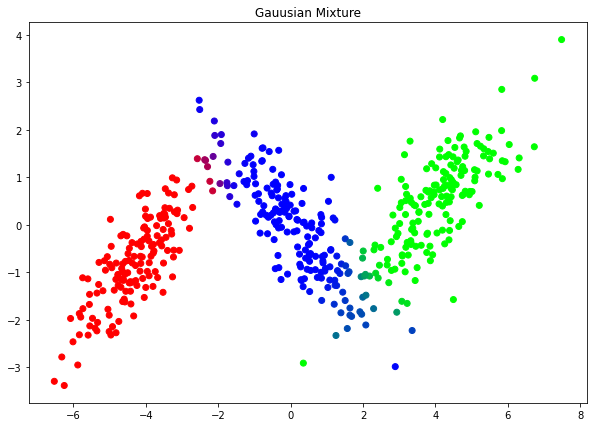

In [9]:
pi = np.array([1/3,1/3,1/3]) 
mu = np.array([
    [-4.0,-0.5],
    [0,0],
    [4.0,0.5]
])
sigma = np.array([
    [[1,0.8],[0.8,1]],
    [[1,-0.8],[-0.8,1]], 
    [[1,0.8],[0.8,1]]
])

X = gm_sampling(n = 500,pi=pi,mu=mu,sigma=sigma)

K_org = 5
km = KMeans(K = K_org) 
cluster,_ = km.fit(X)
l2o = LabelToOnehot()
init_responsibility = l2o.fit_transform(cluster) 

agm = ApproximateGaussianMixture(K = K_org,n_iter=200)
agm.fit(X,initial_responsibility=init_responsibility,reduce_components=True,threshold=1e-2)
responsibility = agm.r 

print(f"K is reduced from {K_org} to {agm.K}")

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.scatter(X[:,0],X[:,1],c=responsibility)
ax.set_title("Gauusian Mixture")
plt.show()

# Predictive Density

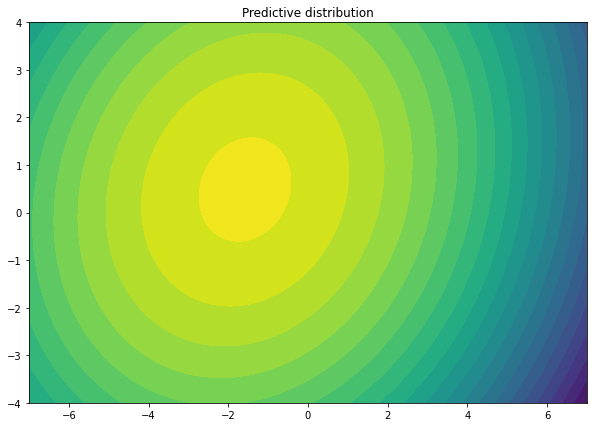

In [10]:
alpha = agm.alpha 
m_k = agm.m_k 
W_k = agm.W_k 
beta = agm.beta 
nu = agm.nu 
D = 2

def Student(data,D,mu,L,nu):
    norm_const = gamma(D/2 + nu/2)/gamma(nu/2) * np.linalg.det(L)**0.5/(np.pi*nu)**(D/2) 
    data -= mu 
    mahalanobis_dist = (data.reshape(-1,1,D)@L@data.reshape(-1,D,1)).ravel()
    st = (1 + mahalanobis_dist/nu)*(-D/2 - nu/2) 
    return norm_const*st

fig,ax = plt.subplots(1,1,figsize=(10,7))
x = np.linspace(-7,7,100)
y = np.linspace(-4,4,100) 
X,Y = np.meshgrid(x,y)

data = np.vstack((X.ravel(),Y.ravel())).T 
prob = np.zeros(data.shape[0])
K = alpha.shape[0] 

for i in range(K):
    L = (nu[i] + 1 - D)*beta[i]/(1 + beta[i])*W_k[i]
    prob += alpha[i]*Student(data,D,m_k[i],L,nu[i]+1-D) 
prob /= alpha.sum()

prob = prob.reshape(100,100)
ax.contourf(X,Y,prob,levels=20)
ax.set_title("Predictive distribution")
plt.show()